Deep Learning
=============

Assignment 2
------------

Previously in `1_notmnist.ipynb`, we created a pickle with formatted datasets for training, development and testing on the [notMNIST dataset](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html).

The goal of this assignment is to progressively train deeper and more accurate models using TensorFlow.

In [1]:
import sys
sys.prefix

'/home/mabelvj/tensorflow'

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
pickle_file = 'exploration.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (8432, 32, 32) (8432,)
Validation set (2811, 32, 32) (2811,)
Test set (2811, 32, 32) (2811,)


In [4]:
image_height = 129
image_width = 23
image_size = 128

image_height = 32
image_width = 32
num_labels = 2

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_width * image_height)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (8432, 1024) (8432, 2)
Validation set (2811, 1024) (2811, 2)
Test set (2811, 1024) (2811, 2)


In [5]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

In [30]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 7000


graph = tf.Graph()
with graph.as_default():

  # Input data.
  # Load the training, validation and test data into constants that are
  # attached to the graph.
  randomized_dataset, randomized_labels = randomize( train_dataset, train_labels)
  tf_train_dataset = tf.constant(randomized_dataset[:train_subset, :]) # still one dimension
  tf_train_labels = tf.constant(randomized_labels[:train_subset])
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # These are the parameters that we are going to be training. The weight
  # matrix will be initialized using random values following a (truncated)
  # normal distribution. The biases get initialized to zero.
  weights = tf.Variable(
    tf.truncated_normal([image_height * image_width, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  # We multiply the inputs with the weight matrix, and add biases. We compute
  # the softmax and cross-entropy (it's one operation in TensorFlow, because
  # it's very common, and it can be optimized). We take the average of this
  # cross-entropy across all training examples: that's our loss.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  #optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
  #decaying learning rate:
  starting_learning_rate = 0.1
  learning_rate = tf.train.exponential_decay(starting_learning_rate, num_steps, 2001, 0.9, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)  
    
  # Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run this computation and iterate:

In [31]:
num_steps = 501
#num_steps = train_dataset.shape[0] // batch_size

#num_steps = 3001
print ("num_steps:%d" %num_steps)

valid_accuracy = []
test_accuracy = []
pred_step = []
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the loss value and the training predictions returned as numpy
    # arrays.
    
    _, l, predictions = session.run([optimizer, loss, train_prediction])
    if (step % 100 == 0):
      print('Loss at step %d: %f' % (step, l))

      print('Training accuracy: %.1f%%' % accuracy(
        predictions, train_labels[:train_subset, :]))

      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
      valid_accuracy.append(accuracy(
        valid_prediction.eval(), valid_labels))
      test_accuracy.append(accuracy(
        test_prediction.eval(), test_labels))
      pred_step.append(step)
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

num_steps:501
Initialized
Loss at step 0: 1372.625000
Training accuracy: 50.4%
Validation accuracy: 50.9%
Loss at step 100: 7652.728027
Training accuracy: 49.2%
Validation accuracy: 80.6%
Loss at step 200: 5165.912598
Training accuracy: 49.2%
Validation accuracy: 85.4%
Loss at step 300: 3120.953125
Training accuracy: 48.9%
Validation accuracy: 86.3%
Loss at step 400: 8056.357910
Training accuracy: 48.9%
Validation accuracy: 73.3%
Loss at step 500: 4451.582520
Training accuracy: 49.2%
Validation accuracy: 76.5%
Test accuracy: 77.4%


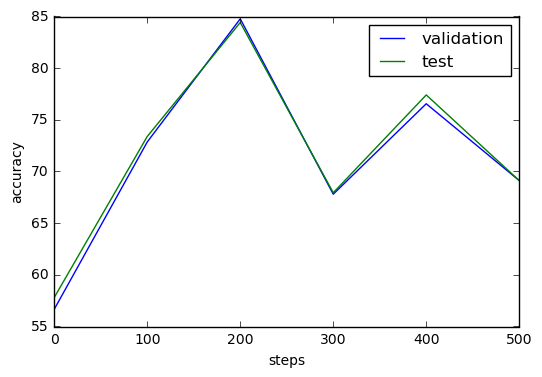

In [29]:
plt.plot(pred_step,valid_accuracy, label= 'validation')
plt.plot(pred_step,test_accuracy, label= 'test')
plt.xlabel('steps')
plt.ylabel('accuracy')
plt.legend()

Let's now switch to stochastic gradient descent training instead, which is much faster.

The graph will be similar, except that instead of holding all the training data into a constant node, we create a `Placeholder` node which will be fed actual data at every call of `session.run()`.

In [32]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_width * image_height))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_width * image_height, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  #optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
  #decaying learning rate:
  starting_learning_rate = 0.1
  learning_rate = tf.train.exponential_decay(starting_learning_rate, num_steps, 2001, 0.9, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)  
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run it:

In [33]:
num_steps = train_dataset.shape[0] // batch_size

#num_steps = 001
print ("num_steps:%d" %num_steps)

valid_accuracy = []
test_accuracy = []
pred_step = []

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    #batch_data = train_dataset[offset:(offset + batch_size), :]
    #batch_labels = train_labels[offset:(offset + batch_size), :]
    batch_data, batch_labels = randomize(
        train_dataset[offset:(offset + batch_size), :],  train_labels[offset:(offset + batch_size), :])
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
      valid_accuracy.append(accuracy(
        valid_prediction.eval(), valid_labels))
      test_accuracy.append(accuracy(
        test_prediction.eval(), test_labels))
      pred_step.append(step)
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


num_steps:65
Initialized
Minibatch loss at step 0: 1288.413574
Minibatch accuracy: 37.5%
Validation accuracy: 60.9%
Test accuracy: 65.7%


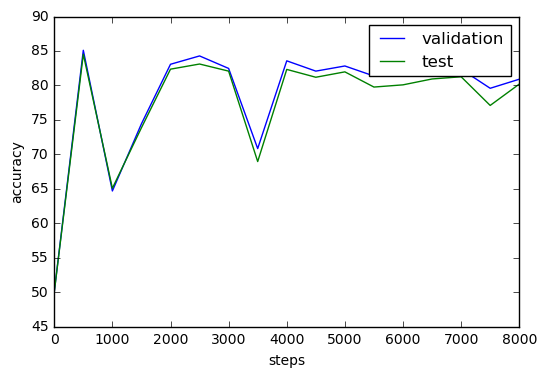

In [44]:
plt.plot(pred_step,valid_accuracy, label= 'validation')
plt.plot(pred_step,test_accuracy, label= 'test')
plt.xlabel('steps')
plt.ylabel('accuracy')
plt.legend()

---
Problem
-------

Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units [nn.relu()](https://www.tensorflow.org/versions/r0.7/api_docs/python/nn.html#relu) and 1024 hidden nodes. This model should improve your validation / test accuracy.

---

In [18]:
batch_size = 500
hidden_nodes= 512
graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)

    # Variables.
  weights1 = tf.Variable(
            tf.truncated_normal([image_size * image_size, hidden_nodes]))
  biases1 = tf.Variable(tf.zeros([ hidden_nodes]))
  weights2 = tf.Variable(tf.truncated_normal([hidden_nodes,num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
   
  def forward_prop(inp):
        h1 = tf.nn.relu(tf.matmul(inp, weights1)+biases1)
        return tf.matmul(h1,weights2) + biases2
    
  # Training computation.
  logits = forward_prop(tf_train_dataset)
    
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(forward_prop(tf_valid_dataset))
  test_prediction = tf.nn.softmax(forward_prop(tf_test_dataset))

In [24]:
def randomize_linear(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

In [27]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.

    X_batch, Y_batch = randomize_linear(
        train_dataset,  train_labels)    
    batch_data = X_batch[offset:(offset + batch_size), :]
    batch_labels = Y_batch[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 519.659302
Minibatch accuracy: 48.2%
Validation accuracy: 74.7%
Minibatch loss at step 500: 0.597418
Minibatch accuracy: 63.0%
Validation accuracy: 62.1%
Minibatch loss at step 1000: 0.537874
Minibatch accuracy: 67.4%
Validation accuracy: 65.0%
Minibatch loss at step 1500: 0.496857
Minibatch accuracy: 70.0%
Validation accuracy: 68.4%
Minibatch loss at step 2000: 0.464113
Minibatch accuracy: 73.4%
Validation accuracy: 69.7%
Minibatch loss at step 2500: 0.435398
Minibatch accuracy: 79.0%
Validation accuracy: 70.5%
Minibatch loss at step 3000: 0.437727
Minibatch accuracy: 75.4%
Validation accuracy: 71.7%
Test accuracy: 72.1%


In [ ]:
plt.plot(pred_step,valid_accuracy, label= 'validation')
plt.plot(pred_step,test_accuracy, label= 'test')
plt.xlabel('steps')
plt.ylabel('accuracy')
plt.legend()